In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:1


In [ ]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [2]:
#Material Properties This link - https://www.mathworks.com/help/pde/ug/nonlinear-heat-transfer-in-a-thin-plate.html#heatTransferThinPlateExample-1
k = 400
rho = 8960
cp = 386
t_z = 0.01
stef_bolt = 5.670373e-8
hc = 1
Ta = 300
emiss = 0.5


In [3]:
label = "Heat_tanh"

x = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,1,100).reshape(-1,1) #t is actually from 0 to 5000, let us scale it to 0 to 1

X,Y,T = np.meshgrid(x,y,t)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xyt = np.hstack((X,Y,T))

initial_pts = np.logical_and(T==0,Y!=0).reshape(-1,)

DBC_pts = (Y == 0).reshape(-1,)


NBC_pts_x0 = (X == 0).reshape(-1,)
NBC_pts_x1 = (X == 1).reshape(-1,)

NBC_pts_y0 = (Y == 0).reshape(-1,)
NBC_pts_y1 = (Y == 1).reshape(-1,)

xyt_initial = xyt[initial_pts,:]
xyt_DBC = xyt[DBC_pts,:]

xyt_NBC_x0 = xyt[NBC_pts_x0,:]
xyt_NBC_x1 = xyt[NBC_pts_x1,:]

#xyt_NBC_y0 = xyt[NBC_pts_y0,:]
xyt_NBC_y1 = xyt[NBC_pts_y1,:]

u_initial = 300*np.ones((np.shape(xyt_initial)[0],1))
u_DBC = 1000*np.ones((np.shape(xyt_DBC)[0],1))

xyt_I_DBC = np.vstack((xyt_initial,xyt_DBC))
#xyt_NBC = np.vstack((xyt_NBC_1,xyt_NBC_2,xyt_NBC_3,xyt_NBC_4))
xyt_NBC_x = np.vstack((xyt_NBC_x0,xyt_NBC_x1))
#xyt_NBC_y = np.vstack((xyt_NBC_y0,xyt_NBC_y1))
xyt_NBC_y = np.vstack((xyt_NBC_y1))

u_I_DBC = np.vstack((u_initial,u_DBC))

xyt_test_tensor = torch.from_numpy(xyt).float().to(device)

lb_xyt = xyt[0]
ub_xyt = xyt[-1]

In [4]:
def trainingdata(N_D,N_N,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    idx = np.random.choice(xyt_I_DBC.shape[0], N_D, replace=False) 
    xyt_D = xyt_I_DBC[idx,:] #choose indices from  set 'idx' (x,t)
    u_D = u_I_DBC[idx].reshape(-1,1)      #choose corresponding u

    idx = np.random.choice(xyt_NBC_x.shape[0], N_D, replace=False) 
    xyt_Nx = xyt_NBC_x[idx,:] #choose indices from  set 'idx' (x,t)

    idx = np.random.choice(xyt_NBC_y.shape[0], N_D, replace=False) 
    xyt_Ny = xyt_NBC_y[idx,:] #choose indices from  set 'idx' (x,t)

    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xyt_coll = lb_xyt + (ub_xyt - lb_xyt)*samples
    xyt_coll = np.vstack((xyt_coll, xyt_D,xyt_Nx,xyt_Ny)) # append training points to collocation points 

    return xyt_coll, xyt_D, u_D, xyt_Nx,xyt_Ny

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
        
#         self.beta = Parameter(torch.ones((50,len(layers)-2)))
#         self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        
        self.beta_val = []
        
        self.n = torch.tensor(1.0)
            
    'foward pass'
    def forward(self,xyt):
        if torch.is_tensor(xyt) != True:         
            xyt = torch.from_numpy(xyt)                
        
        ubxyt = torch.from_numpy(ub_xyt).float().to(device)
        lbxyt = torch.from_numpy(lb_xyt).float().to(device)
    
                      
        #preprocessing input 
        xyt = (xyt - lbxyt)/(ubxyt - lbxyt)
        
        #convert to float
        a = xyt.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
             
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_D(self,xyt_D,u_D):
                
        loss_bc = self.loss_function(self.forward(xyt_D), u_D)
                
        return loss_bc
    
    def loss_N(self,xyt_Nx,xyt_Ny,N_hat):
        
        g1 = xyt_Nx.clone()             
        g1.requires_grad = True
        u1 = self.forward(g1)
        
        u1_x_y_t = autograd.grad(u1,g1,torch.ones([xyt_Nx.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du1_dx = u1_x_y_t[:,[0]]
        
        g2 = xyt_Ny.clone()             
        g2.requires_grad = True
        u2 = self.forward(g2)
        
        u2_x_y_t = autograd.grad(u2,g2,torch.ones([xyt_Ny.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        du2_dy = u2_x_y_t[:,[1]]
               
        loss_N1 = self.loss_function(du1_dx,N_hat)
        loss_N2 = self.loss_function(du2_dy,N_hat)
        
        #return loss_N1+loss_N2       
        return loss_N1 + loss_N2
    
    def loss_PDE(self, xyt_coll, f_hat):
        
        g = xyt_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y_t = autograd.grad(u,g,torch.ones([xyt_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy_tt = autograd.grad(u_x_y_t,g,torch.ones(xyt_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        du_dt = u_x_y_t[:,[2]]
        
        d2u_dx2 = u_xx_yy_tt[:,[0]]
        d2u_dy2 = u_xx_yy_tt[:,[1]]    
        

        f = rho*cp*t_z*du_dt/3000 - k*t_z*(d2u_dx2+d2u_dy2) + 2*hc*(u-Ta) + 2*emiss*stef_bolt*(torch.pow(u,4)-Ta**4) 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat):

        loss_D = self.loss_D(xyt_D,u_D)
        loss_N = self.loss_N(xyt_Nx,xyt_Ny,N_hat)
        loss_f = self.loss_PDE(xyt_coll,f_hat)
        
        loss_val = loss_D + loss_N + loss_f
        
        #print(self.iter,"loss_D:",loss_D.cpu().detach().numpy(),"loss_N:",loss_N.cpu().detach().numpy(),"loss_f:",loss_f.cpu().detach().numpy())
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
        loss = self.loss(xyt_D,u_D,xyt_Nx,xyt_Ny,N_hat,xyt_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xyt_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        #self.beta_val.append(self.alpha.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self,xyt_test_tensor):
        u_pred = self.forward(xyt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [6]:
max_reps = 1

train_loss_full = []
test_loss_full = []
#alpha_full = []
elapsed_time= np.zeros((max_reps,1))

#for reps in range(max_reps):
for reps in range(8,9):
    print(reps)
    
    torch.manual_seed(reps*36)
    N_D = 5000 #Total number of data points for 'y'
    N_N = 3500
    N_f = 10000 #Total number of collocation points 
    
    xyt_coll_np_array, xyt_D_np_array, u_D_np_array,xyt_Nx_np_array,xyt_Ny_np_array = trainingdata(N_D,N_N,N_f,(reps)*22)
        
    xyt_coll = torch.from_numpy(xyt_coll_np_array).float().to(device)
    xyt_D = torch.from_numpy(xyt_D_np_array).float().to(device)
    u_D = torch.from_numpy(u_D_np_array).float().to(device)
    xyt_Nx = torch.from_numpy(xyt_Nx_np_array).float().to(device)
    xyt_Ny = torch.from_numpy(xyt_Ny_np_array).float().to(device)
        
    N_hat = torch.zeros(xyt_Nx.shape[0],1).to(device)    
    f_hat = torch.zeros(xyt_coll.shape[0],1).to(device)

    layers = np.array([3,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    #layers = np.array([3,100,100,100,100,100,100,100,1])

    PINN = Sequentialmodel(layers)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                              max_iter = 10000, 
                              max_eval = None, 
                              tolerance_grad = -1, 
                              tolerance_change = -1, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')



    start_time = time.time()
        
    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    #alpha_full.append(PINN.alpha_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time,  "label": label}
savemat(label+'.mat', mdic)

8
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 1683767.5
1 Train Loss 1682065.1
2 Train Loss 1667887.8
3 Train Loss 1619635.2
4 Train Loss 1510045.9
5 Train Loss 1828981.8
6 Train Loss 1481455.0
7 Train Loss 1453051.0
8 Train Loss 1556142.0
9 Train Loss 1404337.2
10 Train Loss 1347620.5
11 Train Loss 1562894.8
12 Train Loss 1255488.

308 Train Loss 205235.83
309 Train Loss 204819.16
310 Train Loss 205730.83
311 Train Loss 204632.94
312 Train Loss 204478.02
313 Train Loss 204307.12
314 Train Loss 204082.33
315 Train Loss 203863.38
316 Train Loss 203691.8
317 Train Loss 203545.52
318 Train Loss 203443.92
319 Train Loss 203349.27
320 Train Loss 203296.88
321 Train Loss 203166.25
322 Train Loss 202925.36
323 Train Loss 202706.08
324 Train Loss 202966.78
325 Train Loss 202657.05
326 Train Loss 202466.86
327 Train Loss 202230.77
328 Train Loss 202050.84
329 Train Loss 201934.02
330 Train Loss 202125.44
331 Train Loss 201872.27
332 Train Loss 201757.47
333 Train Loss 201693.17
334 Train Loss 201663.16
335 Train Loss 201529.89
336 Train Loss 201439.56
337 Train Loss 201365.34
338 Train Loss 201280.53
339 Train Loss 201260.48
340 Train Loss 201216.7
341 Train Loss 201154.92
342 Train Loss 201060.67
343 Train Loss 200983.89
344 Train Loss 200917.66
345 Train Loss 200847.23
346 Train Loss 200803.36
347 Train Loss 200774.72
34

640 Train Loss 182313.75
641 Train Loss 182293.19
642 Train Loss 182276.14
643 Train Loss 182259.0
644 Train Loss 182233.33
645 Train Loss 182198.89
646 Train Loss 182165.28
647 Train Loss 182134.16
648 Train Loss 182074.12
649 Train Loss 181945.45
650 Train Loss 183708.83
651 Train Loss 181897.17
652 Train Loss 181791.3
653 Train Loss 181713.95
654 Train Loss 181656.5
655 Train Loss 181614.14
656 Train Loss 181567.42
657 Train Loss 181500.94
658 Train Loss 181984.36
659 Train Loss 181483.42
660 Train Loss 181415.94
661 Train Loss 181436.45
662 Train Loss 181289.77
663 Train Loss 181253.48
664 Train Loss 181207.45
665 Train Loss 181041.05
666 Train Loss 180891.25
667 Train Loss 192931.95
668 Train Loss 180951.08
669 Train Loss 180818.2
670 Train Loss 180731.38
671 Train Loss 180687.12
672 Train Loss 180828.17
673 Train Loss 180616.17
674 Train Loss 180836.31
675 Train Loss 180569.02
676 Train Loss 180486.2
677 Train Loss 180488.5
678 Train Loss 180416.8
679 Train Loss 180300.62
680 Tra

971 Train Loss 176075.44
972 Train Loss 175980.64
973 Train Loss 175970.16
974 Train Loss 175964.02
975 Train Loss 175951.62
976 Train Loss 175944.38
977 Train Loss 175934.22
978 Train Loss 175923.56
979 Train Loss 175911.05
980 Train Loss 175900.11
981 Train Loss 175891.22
982 Train Loss 175879.94
983 Train Loss 175855.58
984 Train Loss 175882.23
985 Train Loss 175849.83
986 Train Loss 175831.77
987 Train Loss 175824.73
988 Train Loss 175823.64
989 Train Loss 175812.81
990 Train Loss 175802.58
991 Train Loss 175796.28
992 Train Loss 175790.78
993 Train Loss 175786.75
994 Train Loss 175781.94
995 Train Loss 175777.78
996 Train Loss 175772.36
997 Train Loss 175764.84
998 Train Loss 175759.86
999 Train Loss 175753.58
1000 Train Loss 175748.66
1001 Train Loss 175742.86
1002 Train Loss 175737.98
1003 Train Loss 175730.89
1004 Train Loss 175722.98
1005 Train Loss 175721.64
1006 Train Loss 175716.75
1007 Train Loss 175707.42
1008 Train Loss 175697.8
1009 Train Loss 175689.64
1010 Train Loss 

1292 Train Loss 173143.9
1293 Train Loss 173142.5
1294 Train Loss 173142.61
1295 Train Loss 173141.86
1296 Train Loss 173140.61
1297 Train Loss 173139.5
1298 Train Loss 173138.81
1299 Train Loss 173138.31
1300 Train Loss 173137.3
1301 Train Loss 173137.22
1302 Train Loss 173135.17
1303 Train Loss 173133.12
1304 Train Loss 173129.61
1305 Train Loss 173123.81
1306 Train Loss 173126.94
1307 Train Loss 173122.11
1308 Train Loss 173119.78
1309 Train Loss 173117.73
1310 Train Loss 173115.83
1311 Train Loss 173111.05
1312 Train Loss 173103.23
1313 Train Loss 173185.95
1314 Train Loss 173097.69
1315 Train Loss 173077.98
1316 Train Loss 175813.81
1317 Train Loss 173084.42
1318 Train Loss 173070.12
1319 Train Loss 173037.47
1320 Train Loss 173146.14
1321 Train Loss 173017.78
1322 Train Loss 173139.58
1323 Train Loss 172999.03
1324 Train Loss 173710.5
1325 Train Loss 172986.7
1326 Train Loss 172931.1
1327 Train Loss 172939.12
1328 Train Loss 172868.97
1329 Train Loss 173238.75
1330 Train Loss 172

1612 Train Loss 169273.38
1613 Train Loss 169270.42
1614 Train Loss 169263.02
1615 Train Loss 169272.2
1616 Train Loss 169260.58
1617 Train Loss 169253.86
1618 Train Loss 169248.48
1619 Train Loss 169245.19
1620 Train Loss 169242.92
1621 Train Loss 169241.28
1622 Train Loss 169239.77
1623 Train Loss 169239.03
1624 Train Loss 169238.73
1625 Train Loss 169237.78
1626 Train Loss 169279.78
1627 Train Loss 169237.84
1628 Train Loss 169237.81
1629 Train Loss 169237.84
1630 Train Loss 169238.16
1631 Train Loss 169238.02
1632 Train Loss 169237.78
1633 Train Loss 169279.78
1634 Train Loss 169237.84
1635 Train Loss 169237.81
1636 Train Loss 169237.84
1637 Train Loss 169238.16
1638 Train Loss 169238.02
1639 Train Loss 169237.78
1640 Train Loss 169279.78
1641 Train Loss 169237.84
1642 Train Loss 169237.81
1643 Train Loss 169237.84
1644 Train Loss 169238.16
1645 Train Loss 169238.02
1646 Train Loss 169237.78
1647 Train Loss 169279.78
1648 Train Loss 169237.84
1649 Train Loss 169237.81
1650 Train Lo

1932 Train Loss 169238.02
1933 Train Loss 169237.78
1934 Train Loss 169279.78
1935 Train Loss 169237.84
1936 Train Loss 169237.81
1937 Train Loss 169237.84
1938 Train Loss 169238.16
1939 Train Loss 169238.02
1940 Train Loss 169237.78
1941 Train Loss 169279.78
1942 Train Loss 169237.84
1943 Train Loss 169237.81
1944 Train Loss 169237.84
1945 Train Loss 169238.16
1946 Train Loss 169238.02
1947 Train Loss 169237.78
1948 Train Loss 169279.78
1949 Train Loss 169237.84
1950 Train Loss 169237.81
1951 Train Loss 169237.84
1952 Train Loss 169238.16
1953 Train Loss 169238.02
1954 Train Loss 169237.78
1955 Train Loss 169279.78
1956 Train Loss 169237.84
1957 Train Loss 169237.81
1958 Train Loss 169237.84
1959 Train Loss 169238.16
1960 Train Loss 169238.02
1961 Train Loss 169237.78
1962 Train Loss 169279.78
1963 Train Loss 169237.84
1964 Train Loss 169237.81
1965 Train Loss 169237.84
1966 Train Loss 169238.16
1967 Train Loss 169238.02
1968 Train Loss 169237.78
1969 Train Loss 169279.78
1970 Train L

2251 Train Loss 169237.81
2252 Train Loss 169237.84
2253 Train Loss 169238.16
2254 Train Loss 169238.02
2255 Train Loss 169237.78
2256 Train Loss 169279.78
2257 Train Loss 169237.84
2258 Train Loss 169237.81
2259 Train Loss 169237.84
2260 Train Loss 169238.16
2261 Train Loss 169238.02
2262 Train Loss 169237.78
2263 Train Loss 169279.78
2264 Train Loss 169237.84
2265 Train Loss 169237.81
2266 Train Loss 169237.84
2267 Train Loss 169238.16
2268 Train Loss 169238.02
2269 Train Loss 169237.78
2270 Train Loss 169279.78
2271 Train Loss 169237.84
2272 Train Loss 169237.81
2273 Train Loss 169237.84
2274 Train Loss 169238.16
2275 Train Loss 169238.02
2276 Train Loss 169237.78
2277 Train Loss 169279.78
2278 Train Loss 169237.84
2279 Train Loss 169237.81
2280 Train Loss 169237.84
2281 Train Loss 169238.16
2282 Train Loss 169238.02
2283 Train Loss 169237.78
2284 Train Loss 169279.78
2285 Train Loss 169237.84
2286 Train Loss 169237.81
2287 Train Loss 169237.84
2288 Train Loss 169238.16
2289 Train L

2567 Train Loss 169237.84
2568 Train Loss 169238.16
2569 Train Loss 169238.02
2570 Train Loss 169237.78
2571 Train Loss 169279.78
2572 Train Loss 169237.84
2573 Train Loss 169237.81
2574 Train Loss 169237.84
2575 Train Loss 169238.16
2576 Train Loss 169238.02
2577 Train Loss 169237.78
2578 Train Loss 169279.78
2579 Train Loss 169237.84
2580 Train Loss 169237.81
2581 Train Loss 169237.84
2582 Train Loss 169238.16
2583 Train Loss 169238.02
2584 Train Loss 169237.78
2585 Train Loss 169279.78
2586 Train Loss 169237.84
2587 Train Loss 169237.81
2588 Train Loss 169237.84
2589 Train Loss 169238.16
2590 Train Loss 169238.02
2591 Train Loss 169237.78
2592 Train Loss 169279.78
2593 Train Loss 169237.84
2594 Train Loss 169237.81
2595 Train Loss 169237.84
2596 Train Loss 169238.16
2597 Train Loss 169238.02
2598 Train Loss 169237.78
2599 Train Loss 169279.78
2600 Train Loss 169237.84
2601 Train Loss 169237.81
2602 Train Loss 169237.84
2603 Train Loss 169238.16
2604 Train Loss 169238.02
2605 Train L

2886 Train Loss 169279.78
2887 Train Loss 169237.84
2888 Train Loss 169237.81
2889 Train Loss 169237.84
2890 Train Loss 169238.16
2891 Train Loss 169238.02
2892 Train Loss 169237.78
2893 Train Loss 169279.78
2894 Train Loss 169237.84
2895 Train Loss 169237.81
2896 Train Loss 169237.84
2897 Train Loss 169238.16
2898 Train Loss 169238.02
2899 Train Loss 169237.78
2900 Train Loss 169279.78
2901 Train Loss 169237.84
2902 Train Loss 169237.81
2903 Train Loss 169237.84
2904 Train Loss 169238.16
2905 Train Loss 169238.02
2906 Train Loss 169237.78
2907 Train Loss 169279.78
2908 Train Loss 169237.84
2909 Train Loss 169237.81
2910 Train Loss 169237.84
2911 Train Loss 169238.16
2912 Train Loss 169238.02
2913 Train Loss 169237.78
2914 Train Loss 169279.78
2915 Train Loss 169237.84
2916 Train Loss 169237.81
2917 Train Loss 169237.84
2918 Train Loss 169238.16
2919 Train Loss 169238.02
2920 Train Loss 169237.78
2921 Train Loss 169279.78
2922 Train Loss 169237.84
2923 Train Loss 169237.81
2924 Train L

3203 Train Loss 169237.81
3204 Train Loss 169237.84
3205 Train Loss 169238.16
3206 Train Loss 169238.02
3207 Train Loss 169237.78
3208 Train Loss 169279.78
3209 Train Loss 169237.84
3210 Train Loss 169237.81
3211 Train Loss 169237.84
3212 Train Loss 169238.16
3213 Train Loss 169238.02
3214 Train Loss 169237.78
3215 Train Loss 169279.78
3216 Train Loss 169237.84
3217 Train Loss 169237.81
3218 Train Loss 169237.84
3219 Train Loss 169238.16
3220 Train Loss 169238.02
3221 Train Loss 169237.78
3222 Train Loss 169279.78
3223 Train Loss 169237.84
3224 Train Loss 169237.81
3225 Train Loss 169237.84
3226 Train Loss 169238.16
3227 Train Loss 169238.02
3228 Train Loss 169237.78
3229 Train Loss 169279.78
3230 Train Loss 169237.84
3231 Train Loss 169237.81
3232 Train Loss 169237.84
3233 Train Loss 169238.16
3234 Train Loss 169238.02
3235 Train Loss 169237.78
3236 Train Loss 169279.78
3237 Train Loss 169237.84
3238 Train Loss 169237.81
3239 Train Loss 169237.84
3240 Train Loss 169238.16
3241 Train L

3520 Train Loss 169238.16
3521 Train Loss 169238.02
3522 Train Loss 169237.78
3523 Train Loss 169279.78
3524 Train Loss 169237.84
3525 Train Loss 169237.81
3526 Train Loss 169237.84
3527 Train Loss 169238.16
3528 Train Loss 169238.02
3529 Train Loss 169237.78
3530 Train Loss 169279.78
3531 Train Loss 169237.84
3532 Train Loss 169237.81
3533 Train Loss 169237.84
3534 Train Loss 169238.16
3535 Train Loss 169238.02
3536 Train Loss 169237.78
3537 Train Loss 169279.78
3538 Train Loss 169237.84
3539 Train Loss 169237.81
3540 Train Loss 169237.84
3541 Train Loss 169238.16
3542 Train Loss 169238.02
3543 Train Loss 169237.78
3544 Train Loss 169279.78
3545 Train Loss 169237.84
3546 Train Loss 169237.81
3547 Train Loss 169237.84
3548 Train Loss 169238.16
3549 Train Loss 169238.02
3550 Train Loss 169237.78
3551 Train Loss 169279.78
3552 Train Loss 169237.84
3553 Train Loss 169237.81
3554 Train Loss 169237.84
3555 Train Loss 169238.16
3556 Train Loss 169238.02
3557 Train Loss 169237.78
3558 Train L

3836 Train Loss 169238.02
3837 Train Loss 169237.78
3838 Train Loss 169279.78
3839 Train Loss 169237.84
3840 Train Loss 169237.81
3841 Train Loss 169237.84
3842 Train Loss 169238.16
3843 Train Loss 169238.02
3844 Train Loss 169237.78
3845 Train Loss 169279.78
3846 Train Loss 169237.84
3847 Train Loss 169237.81
3848 Train Loss 169237.84
3849 Train Loss 169238.16
3850 Train Loss 169238.02
3851 Train Loss 169237.78
3852 Train Loss 169279.78
3853 Train Loss 169237.84
3854 Train Loss 169237.81
3855 Train Loss 169237.84
3856 Train Loss 169238.16
3857 Train Loss 169238.02
3858 Train Loss 169237.78
3859 Train Loss 169279.78
3860 Train Loss 169237.84
3861 Train Loss 169237.81
3862 Train Loss 169237.84
3863 Train Loss 169238.16
3864 Train Loss 169238.02
3865 Train Loss 169237.78
3866 Train Loss 169279.78
3867 Train Loss 169237.84
3868 Train Loss 169237.81
3869 Train Loss 169237.84
3870 Train Loss 169238.16
3871 Train Loss 169238.02
3872 Train Loss 169237.78
3873 Train Loss 169279.78
3874 Train L

4152 Train Loss 169237.78
4153 Train Loss 169279.78
4154 Train Loss 169237.84
4155 Train Loss 169237.81
4156 Train Loss 169237.84
4157 Train Loss 169238.16
4158 Train Loss 169238.02
4159 Train Loss 169237.78
4160 Train Loss 169279.78
4161 Train Loss 169237.84
4162 Train Loss 169237.81
4163 Train Loss 169237.84
4164 Train Loss 169238.16
4165 Train Loss 169238.02
4166 Train Loss 169237.78
4167 Train Loss 169279.78
4168 Train Loss 169237.84
4169 Train Loss 169237.81
4170 Train Loss 169237.84
4171 Train Loss 169238.16
4172 Train Loss 169238.02
4173 Train Loss 169237.78
4174 Train Loss 169279.78
4175 Train Loss 169237.84
4176 Train Loss 169237.81
4177 Train Loss 169237.84
4178 Train Loss 169238.16
4179 Train Loss 169238.02
4180 Train Loss 169237.78
4181 Train Loss 169279.78
4182 Train Loss 169237.84
4183 Train Loss 169237.81
4184 Train Loss 169237.84
4185 Train Loss 169238.16
4186 Train Loss 169238.02
4187 Train Loss 169237.78
4188 Train Loss 169279.78
4189 Train Loss 169237.84
4190 Train L

4472 Train Loss 169238.16
4473 Train Loss 169238.02
4474 Train Loss 169237.78
4475 Train Loss 169279.78
4476 Train Loss 169237.84
4477 Train Loss 169237.81
4478 Train Loss 169237.84
4479 Train Loss 169238.16
4480 Train Loss 169238.02
4481 Train Loss 169237.78
4482 Train Loss 169279.78
4483 Train Loss 169237.84
4484 Train Loss 169237.81
4485 Train Loss 169237.84
4486 Train Loss 169238.16
4487 Train Loss 169238.02
4488 Train Loss 169237.78
4489 Train Loss 169279.78
4490 Train Loss 169237.84
4491 Train Loss 169237.81
4492 Train Loss 169237.84
4493 Train Loss 169238.16
4494 Train Loss 169238.02
4495 Train Loss 169237.78
4496 Train Loss 169279.78
4497 Train Loss 169237.84
4498 Train Loss 169237.81
4499 Train Loss 169237.84
4500 Train Loss 169238.16
4501 Train Loss 169238.02
4502 Train Loss 169237.78
4503 Train Loss 169279.78
4504 Train Loss 169237.84
4505 Train Loss 169237.81
4506 Train Loss 169237.84
4507 Train Loss 169238.16
4508 Train Loss 169238.02
4509 Train Loss 169237.78
4510 Train L

4789 Train Loss 169237.78
4790 Train Loss 169279.78
4791 Train Loss 169237.84
4792 Train Loss 169237.81
4793 Train Loss 169237.84
4794 Train Loss 169238.16
4795 Train Loss 169238.02
4796 Train Loss 169237.78
4797 Train Loss 169279.78
4798 Train Loss 169237.84
4799 Train Loss 169237.81
4800 Train Loss 169237.84
4801 Train Loss 169238.16
4802 Train Loss 169238.02
4803 Train Loss 169237.78
4804 Train Loss 169279.78
4805 Train Loss 169237.84
4806 Train Loss 169237.81
4807 Train Loss 169237.84
4808 Train Loss 169238.16
4809 Train Loss 169238.02
4810 Train Loss 169237.78
4811 Train Loss 169279.78
4812 Train Loss 169237.84
4813 Train Loss 169237.81
4814 Train Loss 169237.84
4815 Train Loss 169238.16
4816 Train Loss 169238.02
4817 Train Loss 169237.78
4818 Train Loss 169279.78
4819 Train Loss 169237.84
4820 Train Loss 169237.81
4821 Train Loss 169237.84
4822 Train Loss 169238.16
4823 Train Loss 169238.02
4824 Train Loss 169237.78
4825 Train Loss 169279.78
4826 Train Loss 169237.84
4827 Train L

5105 Train Loss 169279.78
5106 Train Loss 169237.84
5107 Train Loss 169237.81
5108 Train Loss 169237.84
5109 Train Loss 169238.16
5110 Train Loss 169238.02
5111 Train Loss 169237.78
5112 Train Loss 169279.78
5113 Train Loss 169237.84
5114 Train Loss 169237.81
5115 Train Loss 169237.84
5116 Train Loss 169238.16
5117 Train Loss 169238.02
5118 Train Loss 169237.78
5119 Train Loss 169279.78
5120 Train Loss 169237.84
5121 Train Loss 169237.81
5122 Train Loss 169237.84
5123 Train Loss 169238.16
5124 Train Loss 169238.02
5125 Train Loss 169237.78
5126 Train Loss 169279.78
5127 Train Loss 169237.84
5128 Train Loss 169237.81
5129 Train Loss 169237.84
5130 Train Loss 169238.16
5131 Train Loss 169238.02
5132 Train Loss 169237.78
5133 Train Loss 169279.78
5134 Train Loss 169237.84
5135 Train Loss 169237.81
5136 Train Loss 169237.84
5137 Train Loss 169238.16
5138 Train Loss 169238.02
5139 Train Loss 169237.78
5140 Train Loss 169279.78
5141 Train Loss 169237.84
5142 Train Loss 169237.81
5143 Train L

5425 Train Loss 169238.02
5426 Train Loss 169237.78
5427 Train Loss 169279.78
5428 Train Loss 169237.84
5429 Train Loss 169237.81
5430 Train Loss 169237.84
5431 Train Loss 169238.16
5432 Train Loss 169238.02
5433 Train Loss 169237.78
5434 Train Loss 169279.78
5435 Train Loss 169237.84
5436 Train Loss 169237.81
5437 Train Loss 169237.84
5438 Train Loss 169238.16
5439 Train Loss 169238.02
5440 Train Loss 169237.78
5441 Train Loss 169279.78
5442 Train Loss 169237.84
5443 Train Loss 169237.81
5444 Train Loss 169237.84
5445 Train Loss 169238.16
5446 Train Loss 169238.02
5447 Train Loss 169237.78
5448 Train Loss 169279.78
5449 Train Loss 169237.84
5450 Train Loss 169237.81
5451 Train Loss 169237.84
5452 Train Loss 169238.16
5453 Train Loss 169238.02
5454 Train Loss 169237.78
5455 Train Loss 169279.78
5456 Train Loss 169237.84
5457 Train Loss 169237.81
5458 Train Loss 169237.84
5459 Train Loss 169238.16
5460 Train Loss 169238.02
5461 Train Loss 169237.78
5462 Train Loss 169279.78
5463 Train L

5742 Train Loss 169279.78
5743 Train Loss 169237.84
5744 Train Loss 169237.81
5745 Train Loss 169237.84
5746 Train Loss 169238.16
5747 Train Loss 169238.02
5748 Train Loss 169237.78
5749 Train Loss 169279.78
5750 Train Loss 169237.84
5751 Train Loss 169237.81
5752 Train Loss 169237.84
5753 Train Loss 169238.16
5754 Train Loss 169238.02
5755 Train Loss 169237.78
5756 Train Loss 169279.78
5757 Train Loss 169237.84
5758 Train Loss 169237.81
5759 Train Loss 169237.84
5760 Train Loss 169238.16
5761 Train Loss 169238.02
5762 Train Loss 169237.78
5763 Train Loss 169279.78
5764 Train Loss 169237.84
5765 Train Loss 169237.81
5766 Train Loss 169237.84
5767 Train Loss 169238.16
5768 Train Loss 169238.02
5769 Train Loss 169237.78
5770 Train Loss 169279.78
5771 Train Loss 169237.84
5772 Train Loss 169237.81
5773 Train Loss 169237.84
5774 Train Loss 169238.16
5775 Train Loss 169238.02
5776 Train Loss 169237.78
5777 Train Loss 169279.78
5778 Train Loss 169237.84
5779 Train Loss 169237.81
5780 Train L

6059 Train Loss 169237.81
6060 Train Loss 169237.84
6061 Train Loss 169238.16
6062 Train Loss 169238.02
6063 Train Loss 169237.78
6064 Train Loss 169279.78
6065 Train Loss 169237.84
6066 Train Loss 169237.81
6067 Train Loss 169237.84
6068 Train Loss 169238.16
6069 Train Loss 169238.02
6070 Train Loss 169237.78
6071 Train Loss 169279.78
6072 Train Loss 169237.84
6073 Train Loss 169237.81
6074 Train Loss 169237.84
6075 Train Loss 169238.16
6076 Train Loss 169238.02
6077 Train Loss 169237.78
6078 Train Loss 169279.78
6079 Train Loss 169237.84
6080 Train Loss 169237.81
6081 Train Loss 169237.84
6082 Train Loss 169238.16
6083 Train Loss 169238.02
6084 Train Loss 169237.78
6085 Train Loss 169279.78
6086 Train Loss 169237.84
6087 Train Loss 169237.81
6088 Train Loss 169237.84
6089 Train Loss 169238.16
6090 Train Loss 169238.02
6091 Train Loss 169237.78
6092 Train Loss 169279.78
6093 Train Loss 169237.84
6094 Train Loss 169237.81
6095 Train Loss 169237.84
6096 Train Loss 169238.16
6097 Train L

6379 Train Loss 169279.78
6380 Train Loss 169237.84
6381 Train Loss 169237.81
6382 Train Loss 169237.84
6383 Train Loss 169238.16
6384 Train Loss 169238.02
6385 Train Loss 169237.78
6386 Train Loss 169279.78
6387 Train Loss 169237.84
6388 Train Loss 169237.81
6389 Train Loss 169237.84
6390 Train Loss 169238.16
6391 Train Loss 169238.02
6392 Train Loss 169237.78
6393 Train Loss 169279.78
6394 Train Loss 169237.84
6395 Train Loss 169237.81
6396 Train Loss 169237.84
6397 Train Loss 169238.16
6398 Train Loss 169238.02
6399 Train Loss 169237.78
6400 Train Loss 169279.78
6401 Train Loss 169237.84
6402 Train Loss 169237.81
6403 Train Loss 169237.84
6404 Train Loss 169238.16
6405 Train Loss 169238.02
6406 Train Loss 169237.78
6407 Train Loss 169279.78
6408 Train Loss 169237.84
6409 Train Loss 169237.81
6410 Train Loss 169237.84
6411 Train Loss 169238.16
6412 Train Loss 169238.02
6413 Train Loss 169237.78
6414 Train Loss 169279.78
6415 Train Loss 169237.84
6416 Train Loss 169237.81
6417 Train L

6699 Train Loss 169238.02
6700 Train Loss 169237.78
6701 Train Loss 169279.78
6702 Train Loss 169237.84
6703 Train Loss 169237.81
6704 Train Loss 169237.84
6705 Train Loss 169238.16
6706 Train Loss 169238.02
6707 Train Loss 169237.78
6708 Train Loss 169279.78
6709 Train Loss 169237.84
6710 Train Loss 169237.81
6711 Train Loss 169237.84
6712 Train Loss 169238.16
6713 Train Loss 169238.02
6714 Train Loss 169237.78
6715 Train Loss 169279.78
6716 Train Loss 169237.84
6717 Train Loss 169237.81
6718 Train Loss 169237.84
6719 Train Loss 169238.16
6720 Train Loss 169238.02
6721 Train Loss 169237.78
6722 Train Loss 169279.78
6723 Train Loss 169237.84
6724 Train Loss 169237.81
6725 Train Loss 169237.84
6726 Train Loss 169238.16
6727 Train Loss 169238.02
6728 Train Loss 169237.78
6729 Train Loss 169279.78
6730 Train Loss 169237.84
6731 Train Loss 169237.81
6732 Train Loss 169237.84
6733 Train Loss 169238.16
6734 Train Loss 169238.02
6735 Train Loss 169237.78
6736 Train Loss 169279.78
6737 Train L

7016 Train Loss 169279.78
7017 Train Loss 169237.84
7018 Train Loss 169237.81
7019 Train Loss 169237.84
7020 Train Loss 169238.16
7021 Train Loss 169238.02
7022 Train Loss 169237.78
7023 Train Loss 169279.78
7024 Train Loss 169237.84
7025 Train Loss 169237.81
7026 Train Loss 169237.84
7027 Train Loss 169238.16
7028 Train Loss 169238.02
7029 Train Loss 169237.78
7030 Train Loss 169279.78
7031 Train Loss 169237.84
7032 Train Loss 169237.81
7033 Train Loss 169237.84
7034 Train Loss 169238.16
7035 Train Loss 169238.02
7036 Train Loss 169237.78
7037 Train Loss 169279.78
7038 Train Loss 169237.84
7039 Train Loss 169237.81
7040 Train Loss 169237.84
7041 Train Loss 169238.16
7042 Train Loss 169238.02
7043 Train Loss 169237.78
7044 Train Loss 169279.78
7045 Train Loss 169237.84
7046 Train Loss 169237.81
7047 Train Loss 169237.84
7048 Train Loss 169238.16
7049 Train Loss 169238.02
7050 Train Loss 169237.78
7051 Train Loss 169279.78
7052 Train Loss 169237.84
7053 Train Loss 169237.81
7054 Train L

7333 Train Loss 169237.81
7334 Train Loss 169237.84
7335 Train Loss 169238.16
7336 Train Loss 169238.02
7337 Train Loss 169237.78
7338 Train Loss 169279.78
7339 Train Loss 169237.84
7340 Train Loss 169237.81
7341 Train Loss 169237.84
7342 Train Loss 169238.16
7343 Train Loss 169238.02
7344 Train Loss 169237.78
7345 Train Loss 169279.78
7346 Train Loss 169237.84
7347 Train Loss 169237.81
7348 Train Loss 169237.84
7349 Train Loss 169238.16
7350 Train Loss 169238.02
7351 Train Loss 169237.78
7352 Train Loss 169279.78
7353 Train Loss 169237.84
7354 Train Loss 169237.81
7355 Train Loss 169237.84
7356 Train Loss 169238.16
7357 Train Loss 169238.02
7358 Train Loss 169237.78
7359 Train Loss 169279.78
7360 Train Loss 169237.84
7361 Train Loss 169237.81
7362 Train Loss 169237.84
7363 Train Loss 169238.16
7364 Train Loss 169238.02
7365 Train Loss 169237.78
7366 Train Loss 169279.78
7367 Train Loss 169237.84
7368 Train Loss 169237.81
7369 Train Loss 169237.84
7370 Train Loss 169238.16
7371 Train L

7649 Train Loss 169237.84
7650 Train Loss 169238.16
7651 Train Loss 169238.02
7652 Train Loss 169237.78
7653 Train Loss 169279.78
7654 Train Loss 169237.84
7655 Train Loss 169237.81
7656 Train Loss 169237.84
7657 Train Loss 169238.16
7658 Train Loss 169238.02
7659 Train Loss 169237.78
7660 Train Loss 169279.78
7661 Train Loss 169237.84
7662 Train Loss 169237.81
7663 Train Loss 169237.84
7664 Train Loss 169238.16
7665 Train Loss 169238.02
7666 Train Loss 169237.78
7667 Train Loss 169279.78
7668 Train Loss 169237.84
7669 Train Loss 169237.81
7670 Train Loss 169237.84
7671 Train Loss 169238.16
7672 Train Loss 169238.02
7673 Train Loss 169237.78
7674 Train Loss 169279.78
7675 Train Loss 169237.84
7676 Train Loss 169237.81
7677 Train Loss 169237.84
7678 Train Loss 169238.16
7679 Train Loss 169238.02
7680 Train Loss 169237.78
7681 Train Loss 169279.78
7682 Train Loss 169237.84
7683 Train Loss 169237.81
7684 Train Loss 169237.84
7685 Train Loss 169238.16
7686 Train Loss 169238.02
7687 Train L

7966 Train Loss 169238.02
7967 Train Loss 169237.78
7968 Train Loss 169279.78
7969 Train Loss 169237.84
7970 Train Loss 169237.81
7971 Train Loss 169237.84
7972 Train Loss 169238.16
7973 Train Loss 169238.02
7974 Train Loss 169237.78
7975 Train Loss 169279.78
7976 Train Loss 169237.84
7977 Train Loss 169237.81
7978 Train Loss 169237.84
7979 Train Loss 169238.16
7980 Train Loss 169238.02
7981 Train Loss 169237.78
7982 Train Loss 169279.78
7983 Train Loss 169237.84
7984 Train Loss 169237.81
7985 Train Loss 169237.84
7986 Train Loss 169238.16
7987 Train Loss 169238.02
7988 Train Loss 169237.78
7989 Train Loss 169279.78
7990 Train Loss 169237.84
7991 Train Loss 169237.81
7992 Train Loss 169237.84
7993 Train Loss 169238.16
7994 Train Loss 169238.02
7995 Train Loss 169237.78
7996 Train Loss 169279.78
7997 Train Loss 169237.84
7998 Train Loss 169237.81
7999 Train Loss 169237.84
8000 Train Loss 169238.16
8001 Train Loss 169238.02
8002 Train Loss 169237.78
8003 Train Loss 169279.78
8004 Train L

8282 Train Loss 169237.78
8283 Train Loss 169279.78
8284 Train Loss 169237.84
8285 Train Loss 169237.81
8286 Train Loss 169237.84
8287 Train Loss 169238.16
8288 Train Loss 169238.02
8289 Train Loss 169237.78
8290 Train Loss 169279.78
8291 Train Loss 169237.84
8292 Train Loss 169237.81
8293 Train Loss 169237.84
8294 Train Loss 169238.16
8295 Train Loss 169238.02
8296 Train Loss 169237.78
8297 Train Loss 169279.78
8298 Train Loss 169237.84
8299 Train Loss 169237.81
8300 Train Loss 169237.84
8301 Train Loss 169238.16
8302 Train Loss 169238.02
8303 Train Loss 169237.78
8304 Train Loss 169279.78
8305 Train Loss 169237.84
8306 Train Loss 169237.81
8307 Train Loss 169237.84
8308 Train Loss 169238.16
8309 Train Loss 169238.02
8310 Train Loss 169237.78
8311 Train Loss 169279.78
8312 Train Loss 169237.84
8313 Train Loss 169237.81
8314 Train Loss 169237.84
8315 Train Loss 169238.16
8316 Train Loss 169238.02
8317 Train Loss 169237.78
8318 Train Loss 169279.78
8319 Train Loss 169237.84
8320 Train L

8601 Train Loss 169237.84
8602 Train Loss 169238.16
8603 Train Loss 169238.02
8604 Train Loss 169237.78
8605 Train Loss 169279.78
8606 Train Loss 169237.84
8607 Train Loss 169237.81
8608 Train Loss 169237.84
8609 Train Loss 169238.16
8610 Train Loss 169238.02
8611 Train Loss 169237.78
8612 Train Loss 169279.78
8613 Train Loss 169237.84
8614 Train Loss 169237.81
8615 Train Loss 169237.84
8616 Train Loss 169238.16
8617 Train Loss 169238.02
8618 Train Loss 169237.78
8619 Train Loss 169279.78
8620 Train Loss 169237.84
8621 Train Loss 169237.81
8622 Train Loss 169237.84
8623 Train Loss 169238.16
8624 Train Loss 169238.02
8625 Train Loss 169237.78
8626 Train Loss 169279.78
8627 Train Loss 169237.84
8628 Train Loss 169237.81
8629 Train Loss 169237.84
8630 Train Loss 169238.16
8631 Train Loss 169238.02
8632 Train Loss 169237.78
8633 Train Loss 169279.78
8634 Train Loss 169237.84
8635 Train Loss 169237.81
8636 Train Loss 169237.84
8637 Train Loss 169238.16
8638 Train Loss 169238.02
8639 Train L

8918 Train Loss 169238.02
8919 Train Loss 169237.78
8920 Train Loss 169279.78
8921 Train Loss 169237.84
8922 Train Loss 169237.81
8923 Train Loss 169237.84
8924 Train Loss 169238.16
8925 Train Loss 169238.02
8926 Train Loss 169237.78
8927 Train Loss 169279.78
8928 Train Loss 169237.84
8929 Train Loss 169237.81
8930 Train Loss 169237.84
8931 Train Loss 169238.16
8932 Train Loss 169238.02
8933 Train Loss 169237.78
8934 Train Loss 169279.78
8935 Train Loss 169237.84
8936 Train Loss 169237.81
8937 Train Loss 169237.84
8938 Train Loss 169238.16
8939 Train Loss 169238.02
8940 Train Loss 169237.78
8941 Train Loss 169279.78
8942 Train Loss 169237.84
8943 Train Loss 169237.81
8944 Train Loss 169237.84
8945 Train Loss 169238.16
8946 Train Loss 169238.02
8947 Train Loss 169237.78
8948 Train Loss 169279.78
8949 Train Loss 169237.84
8950 Train Loss 169237.81
8951 Train Loss 169237.84
8952 Train Loss 169238.16
8953 Train Loss 169238.02
8954 Train Loss 169237.78
8955 Train Loss 169279.78
8956 Train L

9235 Train Loss 169279.78
9236 Train Loss 169237.84
9237 Train Loss 169237.81
9238 Train Loss 169237.84
9239 Train Loss 169238.16
9240 Train Loss 169238.02
9241 Train Loss 169237.78
9242 Train Loss 169279.78
9243 Train Loss 169237.84
9244 Train Loss 169237.81
9245 Train Loss 169237.84
9246 Train Loss 169238.16
9247 Train Loss 169238.02
9248 Train Loss 169237.78
9249 Train Loss 169279.78
9250 Train Loss 169237.84
9251 Train Loss 169237.81
9252 Train Loss 169237.84
9253 Train Loss 169238.16
9254 Train Loss 169238.02
9255 Train Loss 169237.78
9256 Train Loss 169279.78
9257 Train Loss 169237.84
9258 Train Loss 169237.81
9259 Train Loss 169237.84
9260 Train Loss 169238.16
9261 Train Loss 169238.02
9262 Train Loss 169237.78
9263 Train Loss 169279.78
9264 Train Loss 169237.84
9265 Train Loss 169237.81
9266 Train Loss 169237.84
9267 Train Loss 169238.16
9268 Train Loss 169238.02
9269 Train Loss 169237.78
9270 Train Loss 169279.78
9271 Train Loss 169237.84
9272 Train Loss 169237.81
9273 Train L

9555 Train Loss 169238.02
9556 Train Loss 169237.78
9557 Train Loss 169279.78
9558 Train Loss 169237.84
9559 Train Loss 169237.81
9560 Train Loss 169237.84
9561 Train Loss 169238.16
9562 Train Loss 169238.02
9563 Train Loss 169237.78
9564 Train Loss 169279.78
9565 Train Loss 169237.84
9566 Train Loss 169237.81
9567 Train Loss 169237.84
9568 Train Loss 169238.16
9569 Train Loss 169238.02
9570 Train Loss 169237.78
9571 Train Loss 169279.78
9572 Train Loss 169237.84
9573 Train Loss 169237.81
9574 Train Loss 169237.84
9575 Train Loss 169238.16
9576 Train Loss 169238.02
9577 Train Loss 169237.78
9578 Train Loss 169279.78
9579 Train Loss 169237.84
9580 Train Loss 169237.81
9581 Train Loss 169237.84
9582 Train Loss 169238.16
9583 Train Loss 169238.02
9584 Train Loss 169237.78
9585 Train Loss 169279.78
9586 Train Loss 169237.84
9587 Train Loss 169237.81
9588 Train Loss 169237.84
9589 Train Loss 169238.16
9590 Train Loss 169238.02
9591 Train Loss 169237.78
9592 Train Loss 169279.78
9593 Train L

9874 Train Loss 169237.81
9875 Train Loss 169237.84
9876 Train Loss 169238.16
9877 Train Loss 169238.02
9878 Train Loss 169237.78
9879 Train Loss 169279.78
9880 Train Loss 169237.84
9881 Train Loss 169237.81
9882 Train Loss 169237.84
9883 Train Loss 169238.16
9884 Train Loss 169238.02
9885 Train Loss 169237.78
9886 Train Loss 169279.78
9887 Train Loss 169237.84
9888 Train Loss 169237.81
9889 Train Loss 169237.84
9890 Train Loss 169238.16
9891 Train Loss 169238.02
9892 Train Loss 169237.78
9893 Train Loss 169279.78
9894 Train Loss 169237.84
9895 Train Loss 169237.81
9896 Train Loss 169237.84
9897 Train Loss 169238.16
9898 Train Loss 169238.02
9899 Train Loss 169237.78
9900 Train Loss 169279.78
9901 Train Loss 169237.84
9902 Train Loss 169237.81
9903 Train Loss 169237.84
9904 Train Loss 169238.16
9905 Train Loss 169238.02
9906 Train Loss 169237.78
9907 Train Loss 169279.78
9908 Train Loss 169237.84
9909 Train Loss 169237.81
9910 Train Loss 169237.84
9911 Train Loss 169238.16
9912 Train L

10186 Train Loss 169237.78
10187 Train Loss 169279.78
10188 Train Loss 169237.84
10189 Train Loss 169237.81
10190 Train Loss 169237.84
10191 Train Loss 169238.16
10192 Train Loss 169238.02
10193 Train Loss 169237.78
10194 Train Loss 169279.78
10195 Train Loss 169237.84
10196 Train Loss 169237.81
10197 Train Loss 169237.84
10198 Train Loss 169238.16
10199 Train Loss 169238.02
10200 Train Loss 169237.78
10201 Train Loss 169279.78
10202 Train Loss 169237.84
10203 Train Loss 169237.81
10204 Train Loss 169237.84
10205 Train Loss 169238.16
10206 Train Loss 169238.02
10207 Train Loss 169237.78
10208 Train Loss 169279.78
10209 Train Loss 169237.84
10210 Train Loss 169237.81
10211 Train Loss 169237.84
10212 Train Loss 169238.16
10213 Train Loss 169238.02
10214 Train Loss 169237.78
10215 Train Loss 169279.78
10216 Train Loss 169237.84
10217 Train Loss 169237.81
10218 Train Loss 169237.84
10219 Train Loss 169238.16
10220 Train Loss 169238.02
10221 Train Loss 169237.78
10222 Train Loss 169279.78
1

10492 Train Loss 169238.16
10493 Train Loss 169238.02
10494 Train Loss 169237.78
10495 Train Loss 169279.78
10496 Train Loss 169237.84
10497 Train Loss 169237.81
10498 Train Loss 169237.84
10499 Train Loss 169238.16
10500 Train Loss 169238.02
10501 Train Loss 169237.78
10502 Train Loss 169279.78
10503 Train Loss 169237.84
10504 Train Loss 169237.81
10505 Train Loss 169237.84
10506 Train Loss 169238.16
10507 Train Loss 169238.02
10508 Train Loss 169237.78
10509 Train Loss 169279.78
10510 Train Loss 169237.84
10511 Train Loss 169237.81
10512 Train Loss 169237.84
10513 Train Loss 169238.16
10514 Train Loss 169238.02
10515 Train Loss 169237.78
10516 Train Loss 169279.78
10517 Train Loss 169237.84
10518 Train Loss 169237.81
10519 Train Loss 169237.84
10520 Train Loss 169238.16
10521 Train Loss 169238.02
10522 Train Loss 169237.78
10523 Train Loss 169279.78
10524 Train Loss 169237.84
10525 Train Loss 169237.81
10526 Train Loss 169237.84
10527 Train Loss 169238.16
10528 Train Loss 169238.02
1

10796 Train Loss 169279.78
10797 Train Loss 169237.84
10798 Train Loss 169237.81
10799 Train Loss 169237.84
10800 Train Loss 169238.16
10801 Train Loss 169238.02
10802 Train Loss 169237.78
10803 Train Loss 169279.78
10804 Train Loss 169237.84
10805 Train Loss 169237.81
10806 Train Loss 169237.84
10807 Train Loss 169238.16
10808 Train Loss 169238.02
10809 Train Loss 169237.78
10810 Train Loss 169279.78
10811 Train Loss 169237.84
10812 Train Loss 169237.81
10813 Train Loss 169237.84
10814 Train Loss 169238.16
10815 Train Loss 169238.02
10816 Train Loss 169237.78
10817 Train Loss 169279.78
10818 Train Loss 169237.84
10819 Train Loss 169237.81
10820 Train Loss 169237.84
10821 Train Loss 169238.16
10822 Train Loss 169238.02
10823 Train Loss 169237.78
10824 Train Loss 169279.78
10825 Train Loss 169237.84
10826 Train Loss 169237.81
10827 Train Loss 169237.84
10828 Train Loss 169238.16
10829 Train Loss 169238.02
10830 Train Loss 169237.78
10831 Train Loss 169279.78
10832 Train Loss 169237.84
1

11103 Train Loss 169237.78
11104 Train Loss 169279.78
11105 Train Loss 169237.84
11106 Train Loss 169237.81
11107 Train Loss 169237.84
11108 Train Loss 169238.16
11109 Train Loss 169238.02
11110 Train Loss 169237.78
11111 Train Loss 169279.78
11112 Train Loss 169237.84
11113 Train Loss 169237.81
11114 Train Loss 169237.84
11115 Train Loss 169238.16
11116 Train Loss 169238.02
11117 Train Loss 169237.78
11118 Train Loss 169279.78
11119 Train Loss 169237.84
11120 Train Loss 169237.81
11121 Train Loss 169237.84
11122 Train Loss 169238.16
11123 Train Loss 169238.02
11124 Train Loss 169237.78
11125 Train Loss 169279.78
11126 Train Loss 169237.84
11127 Train Loss 169237.81
11128 Train Loss 169237.84
11129 Train Loss 169238.16
11130 Train Loss 169238.02
11131 Train Loss 169237.78
11132 Train Loss 169279.78
11133 Train Loss 169237.84
11134 Train Loss 169237.81
11135 Train Loss 169237.84
11136 Train Loss 169238.16
11137 Train Loss 169238.02
11138 Train Loss 169237.78
11139 Train Loss 169279.78
1

11410 Train Loss 169238.02
11411 Train Loss 169237.78
11412 Train Loss 169279.78
11413 Train Loss 169237.84
11414 Train Loss 169237.81
11415 Train Loss 169237.84
11416 Train Loss 169238.16
11417 Train Loss 169238.02
11418 Train Loss 169237.78
11419 Train Loss 169279.78
11420 Train Loss 169237.84
11421 Train Loss 169237.81
11422 Train Loss 169237.84
11423 Train Loss 169238.16
11424 Train Loss 169238.02
11425 Train Loss 169237.78
11426 Train Loss 169279.78
11427 Train Loss 169237.84
11428 Train Loss 169237.81
11429 Train Loss 169237.84
11430 Train Loss 169238.16
11431 Train Loss 169238.02
11432 Train Loss 169237.78
11433 Train Loss 169279.78
11434 Train Loss 169237.84
11435 Train Loss 169237.81
11436 Train Loss 169237.84
11437 Train Loss 169238.16
11438 Train Loss 169238.02
11439 Train Loss 169237.78
11440 Train Loss 169279.78
11441 Train Loss 169237.84
11442 Train Loss 169237.81
11443 Train Loss 169237.84
11444 Train Loss 169238.16
11445 Train Loss 169238.02
11446 Train Loss 169237.78
1

11715 Train Loss 169237.81
11716 Train Loss 169237.84
11717 Train Loss 169238.16
11718 Train Loss 169238.02
11719 Train Loss 169237.78
11720 Train Loss 169279.78
11721 Train Loss 169237.84
11722 Train Loss 169237.81
11723 Train Loss 169237.84
11724 Train Loss 169238.16
11725 Train Loss 169238.02
11726 Train Loss 169237.78
11727 Train Loss 169279.78
11728 Train Loss 169237.84
11729 Train Loss 169237.81
11730 Train Loss 169237.84
11731 Train Loss 169238.16
11732 Train Loss 169238.02
11733 Train Loss 169237.78
11734 Train Loss 169279.78
11735 Train Loss 169237.84
11736 Train Loss 169237.81
11737 Train Loss 169237.84
11738 Train Loss 169238.16
11739 Train Loss 169238.02
11740 Train Loss 169237.78
11741 Train Loss 169279.78
11742 Train Loss 169237.84
11743 Train Loss 169237.81
11744 Train Loss 169237.84
11745 Train Loss 169238.16
11746 Train Loss 169238.02
11747 Train Loss 169237.78
11748 Train Loss 169279.78
11749 Train Loss 169237.84
11750 Train Loss 169237.81
11751 Train Loss 169237.84
1

12019 Train Loss 169238.02
12020 Train Loss 169237.78
12021 Train Loss 169279.78
12022 Train Loss 169237.84
12023 Train Loss 169237.81
12024 Train Loss 169237.84
12025 Train Loss 169238.16
12026 Train Loss 169238.02
12027 Train Loss 169237.78
12028 Train Loss 169279.78
12029 Train Loss 169237.84
12030 Train Loss 169237.81
12031 Train Loss 169237.84
12032 Train Loss 169238.16
12033 Train Loss 169238.02
12034 Train Loss 169237.78
12035 Train Loss 169279.78
12036 Train Loss 169237.84
12037 Train Loss 169237.81
12038 Train Loss 169237.84
12039 Train Loss 169238.16
12040 Train Loss 169238.02
12041 Train Loss 169237.78
12042 Train Loss 169279.78
12043 Train Loss 169237.84
12044 Train Loss 169237.81
12045 Train Loss 169237.84
12046 Train Loss 169238.16
12047 Train Loss 169238.02
12048 Train Loss 169237.78
12049 Train Loss 169279.78
12050 Train Loss 169237.84
12051 Train Loss 169237.81
12052 Train Loss 169237.84
12053 Train Loss 169238.16
12054 Train Loss 169238.02
12055 Train Loss 169237.78
1

12327 Train Loss 169238.02
12328 Train Loss 169237.78
12329 Train Loss 169279.78
12330 Train Loss 169237.84
12331 Train Loss 169237.81
12332 Train Loss 169237.84
12333 Train Loss 169238.16
12334 Train Loss 169238.02
12335 Train Loss 169237.78
12336 Train Loss 169279.78
12337 Train Loss 169237.84
12338 Train Loss 169237.81
12339 Train Loss 169237.84
12340 Train Loss 169238.16
12341 Train Loss 169238.02
12342 Train Loss 169237.78
12343 Train Loss 169279.78
12344 Train Loss 169237.84
12345 Train Loss 169237.81
12346 Train Loss 169237.84
12347 Train Loss 169238.16
12348 Train Loss 169238.02
12349 Train Loss 169237.78
12350 Train Loss 169279.78
12351 Train Loss 169237.84
12352 Train Loss 169237.81
12353 Train Loss 169237.84
12354 Train Loss 169238.16
12355 Train Loss 169238.02
12356 Train Loss 169237.78
12357 Train Loss 169279.78
12358 Train Loss 169237.84
12359 Train Loss 169237.81
12360 Train Loss 169237.84
12361 Train Loss 169238.16
12362 Train Loss 169238.02
12363 Train Loss 169237.78
1

IndexError: index 8 is out of bounds for axis 0 with size 1

In [7]:
del xyt_coll
del xyt_D

In [14]:
xyt_test_tensor[500000:,:].shape

torch.Size([500000, 3])

In [8]:
u_pred = PINN.test(xyt_test_tensor)
u_pred_3d = u_pred.reshape(100,100,100,order = 'F')

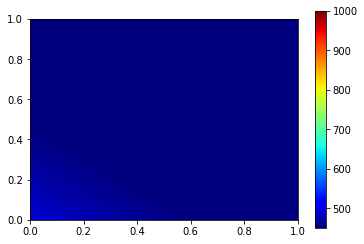

In [9]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.flipud(u_pred_3d[:,:,50]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
fig.colorbar(img3, orientation='vertical')

In [10]:
import subprocess
import os

In [ ]:
def generate_video():
    for i in range(100):
        #plt.imshow(img[i], cmap=cm.Greys_r)
        img3 = ax.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
        
        plt.savefig("stan_heat_%02d.png" % i)

    #os.chdir()
    subprocess.call(['ffmpeg', '-framerate', '8', '-i', 'stan_heat_%02d.png', '-r', '10', '-pix_fmt', 'yuv420p','Stan_transient.mp4'])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [ ]:
generate_video()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


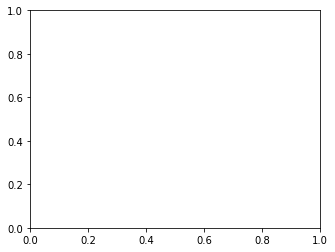

In [11]:
import matplotlib.animation as animation

fig, ax = plt.subplots(1,1)
# img = [] # some array of images
frames = [] # for storing the generated images
# fig = plt.figure()
for i in range(100):
#     p1 = ax.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)
#     fig.colorbar(p1, orientation='vertical',ax=ax)
    frames.append([plt.imshow(np.flipud(u_pred_3d[:,:,i]),vmax =1000,vmin=450,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)])
    print(i)

ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
#ani.save('movie.mp4')
plt.show()

In [12]:
writergif = animation.PillowWriter(fps=10)
ani.save('tanh_Thinplate_movie.gif',writer=writergif)

In [ ]:
writervideo = animation.FFMpegWriter(fps=60) 
ani.save('Stan_Thinplate_movie1.gif',writer=writervideo)

In [ ]:
np.max(u_pred_3d[:,:,50])

In [ ]:
plt.plot(u_pred_3d[50,99,:])

In [ ]:
a = 0
for i in range(10):
    a = a + test_loss_full[i][-1]
print(a/10)

In [ ]:
a = 0
for i in range(10):
    a = a + train_loss_full[i][-1]
print(a/10)